# Testing different artefact correction algorithms
Evaluate different artefact correction: 1) no correction; 2) Kubios artefact method and 3) Remove beats that deviate 20% from the median (11 samples). Test how different artifact correction methods affetec HRV metrics.
- Time-Domain: RMSSD in a 10 sec window
- Frequency-Domain: LF and HF in 120 sec window


In [1]:
import sys
# mac
sys.path.append('/Users/tiagorodrigues/Documents/GitHub/NeuroKit')

import scipy
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import neurokit2 as nk
import matplotlib as mat

1) Case study: *20200405-TR-FWv2.txt* , from rest to exercise
### 1.1) No artefact correction  

In [2]:
# NO ARTEFACT CORRECTION
# Load ECG session
pathname = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data"
activity = "Activities"
record = "20200405-TR-FWv2.txt"
pathname + "/" + activity + "/" + record

f = open(pathname + "/" + activity + "/" + record, 'r')
ecg = f.readlines()[4:]
f.close()

sampling_rate = 250

# Window size for epoches
time_window = 10
freq_window = 120

# Clean ECG (no pre-processing method using ASI)
ecg_cleaned = nk.ecg_clean(ecg,sampling_rate=sampling_rate, method ='asi')

# R-peaks detection
instant_peaks, rpeaks_nocorrection, = nk.ecg_peaks(ecg_cleaned = ecg_cleaned, sampling_rate = sampling_rate,correct_artifacts = False)
rate = nk.signal_rate(rpeaks_nocorrection,sampling_rate = sampling_rate,desired_length = len(ecg_cleaned))

#quality = nk.ecg_quality(ecg_cleaned, rpeaks = None, sampling_rate = sampling_rate)
#signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate,"ECG_Quality": quality})

signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate})
                                    
# Have the right struture for epochs
signals = pd.concat([signals, instant_peaks], axis=1)

# Create epochs of the ecg signal for 10sec asnd 2min windows
ecg_epochs_time = nk.epochs_create(signals, sampling_rate = 250, epochs_end = time_window)
ecg_epochs_freq = nk.epochs_create(signals, sampling_rate = 250, epochs_end = freq_window)

# Compute HRV metrics over the ecg_epochs
hrv_epoches_nocorrection10 = nk.ecg_intervalrelated(ecg_epochs_time,sampling_rate = 250)
hrv_epoches_nocorrection120 = nk.ecg_intervalrelated(ecg_epochs_freq,sampling_rate = 250)

### 1.2) Kubios: Lipponen & Tarvainen (2019) 

In [3]:
# Kubios: Lipponen & Tarvainen (2019) 
# R-peaks detection
instant_peaks, rpeaks_kubios, = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,sampling_rate=sampling_rate,correct_artifacts=True,methodcorrect='kubios')
rate = nk.signal_rate(rpeaks_kubios,sampling_rate=sampling_rate,desired_length=len(ecg_cleaned))

#quality = nk.ecg_quality(ecg_cleaned, rpeaks=None, sampling_rate=sampling_rate)
#signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate,"ECG_Quality": quality})                
signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate})

    
# Have the right struture for epochs
signals = pd.concat([signals, instant_peaks], axis=1)

# Create epochs of the ecg signal
ecg_epochs_time = nk.epochs_create(signals, sampling_rate=250, epochs_end = time_window)
ecg_epochs_freq = nk.epochs_create(signals, sampling_rate=250, epochs_end = freq_window)

# Compute HRV metrics over the ecg_epochs
hrv_epoches_correctionkubios10 = nk.ecg_intervalrelated(ecg_epochs_time,sampling_rate = 250)
hrv_epoches_correctionkubios120 = nk.ecg_intervalrelated(ecg_epochs_freq,sampling_rate = 250)

### 1.3) Remove RR-intervals based on 20% relative difference

In [4]:
# Deviation 20% from the mean
# R-peaks detection
instant_peaks, rpeaks_20 = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,sampling_rate=sampling_rate,correct_artifacts=True,methodcorrect='asi')
rate = nk.signal_rate(rpeaks_20,sampling_rate=sampling_rate,desired_length=len(ecg_cleaned))

#quality = nk.ecg_quality(ecg_cleaned, rpeaks=None, sampling_rate=sampling_rate)
#signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate,"ECG_Quality": quality})
signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate})


# Have the right struture for epochs
signals = pd.concat([signals, instant_peaks], axis=1)

# Create epochs of the ecg signal
ecg_epochs_time = nk.epochs_create(signals, sampling_rate=250, epochs_end = time_window)
ecg_epochs_freq = nk.epochs_create(signals, sampling_rate=250, epochs_end = freq_window)

# Compute HRV metrics over the ecg_epochs
hrv_epoches_correctionmedian10 = nk.ecg_intervalrelated(ecg_epochs_time,sampling_rate=250)
hrv_epoches_correctionmedian120 = nk.ecg_intervalrelated(ecg_epochs_freq,sampling_rate=250)

## Time and Frequency domain features

/Users/tiagorodrigues/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


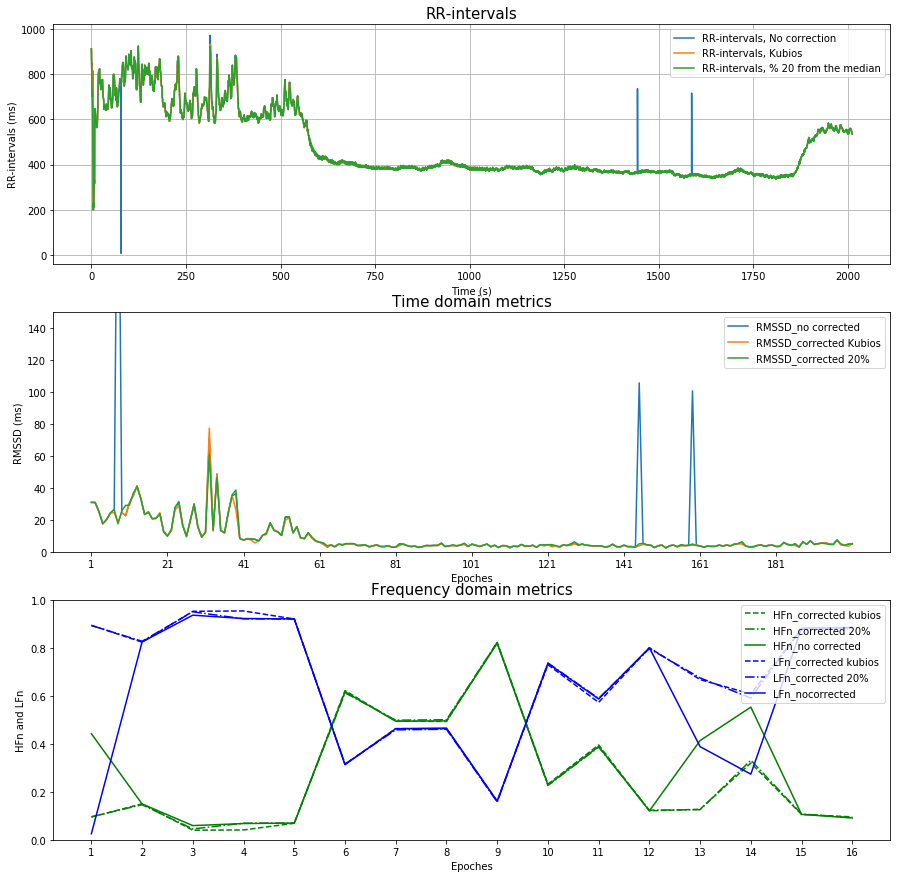

In [5]:
# Plot RR-intervals and corrected 
fig1, ax1 = plt.subplots(figsize=(15,15));
plt.subplot(3,1,1)

rr_nocorrectiontime = np.divide(rpeaks_nocorrection['ECG_R_Peaks'][:-1], sampling_rate)
rr_kubiostime = np.divide(rpeaks_kubios['ECG_R_Peaks'][:-1], sampling_rate)
rr_peaks20time = np.divide(rpeaks_20['ECG_R_Peaks'][:-1], sampling_rate)

plt.subplot(3,1,1)
plt.plot(rr_nocorrectiontime, (1000/sampling_rate) * np.diff(rpeaks_nocorrection['ECG_R_Peaks']),label='RR-intervals, No correction')
plt.plot(rr_kubiostime, (1000/sampling_rate) * np.diff(rpeaks_kubios['ECG_R_Peaks']),label ='RR-intervals, Kubios')
plt.plot(rr_peaks20time, (1000/sampling_rate) * np.diff(rpeaks_20['ECG_R_Peaks']),label='RR-intervals, % 20 from the median')
plt.xlabel('Time (s)')
plt.grid()
plt.ylabel('RR-intervals (ms)')
plt.title('RR-intervals', size = 15)
plt.legend()


# Epoches of 10 sec - Time Domain
# set first values as 0
hrv_epoches_nocorrection10['HRV_RMSSD'][0] = hrv_epoches_nocorrection10['HRV_RMSSD'][1]  
hrv_epoches_correctionkubios10['HRV_RMSSD'][0] = hrv_epoches_correctionkubios10['HRV_RMSSD'][1]  
hrv_epoches_correctionmedian10['HRV_RMSSD'][0] = hrv_epoches_correctionkubios10['HRV_RMSSD'][1]  

plt.subplot(3,1,2)
plt.plot(hrv_epoches_nocorrection10['HRV_RMSSD'],label='RMSSD_no corrected')
plt.plot(hrv_epoches_correctionkubios10['HRV_RMSSD'],label='RMSSD_corrected Kubios')
plt.plot(hrv_epoches_correctionmedian10['HRV_RMSSD'],label='RMSSD_corrected 20%')
plt.ylim([0, 150]);
plt.xticks(np.arange(0, 200, step=20))
plt.xlabel('Epoches')
plt.ylabel('RMSSD (ms)')
plt.title('Time domain metrics',size = 15)
plt.legend();


# Epoches of 120 sec - Freq Domain
plt.subplot(3,1,3)
plt.plot(hrv_epoches_correctionkubios120['HRV_HFn'],'g--',label='HFn_corrected kubios')
plt.plot(hrv_epoches_correctionmedian120['HRV_HFn'],'g-.',label='HFn_corrected 20%')
plt.plot(hrv_epoches_nocorrection120['HRV_HFn'],'g',label ='HFn_no corrected' )
plt.plot(hrv_epoches_correctionkubios120['HRV_LFn'],'b--',label= 'LFn_corrected kubios')
plt.plot(hrv_epoches_correctionmedian120['HRV_LFn'],'b-.',label= 'LFn_corrected 20%')
plt.plot(hrv_epoches_nocorrection120['HRV_LFn'],'b',label = 'LFn_nocorrected')
plt.ylim([0, 1]);
plt.xlabel('Epoches')
plt.title('Frequency domain metrics',size = 15)
plt.ylabel('HFn and LFn')
plt.legend(loc = 'upper right');

### Results
- missed detected beats cause sharp artefacts in the Time-Domain metrics.
- missed beats wrongly classified as ectopic are interpolated, resulting in artefacts in the time-domain. The effects of the interpolation in the frequency metrics is not significative.
- kubios vs corrected20% showed similar results for time and frequency metrics, appart from the artefact at *t = 3000 s*.

2) Case study: *20200508-SS-Belt.txt* , from rest -> exercise -> rest


In [6]:
# NO ARTEFACT CORRECTION
# Load ECG session
pathname = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data"
activity = "Activities"
record = "20200508-SS-Belt.txt"
pathname + "/" + activity + "/" + record

f = open(pathname + "/" + activity + "/" + record, 'r')
ecg = f.readlines()[4:]
f.close()

# Sampling rate
sampling_rate = 250

# Window size for epoches
time_window = 10
freq_window = 120

# Clean ECG (no pre-processing method using ASI)
ecg_cleaned = nk.ecg_clean(ecg,sampling_rate=sampling_rate, method='asi')

# R-peaks detection
instant_peaks, rpeaks_nocorrection, = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,sampling_rate=sampling_rate,methodcorrect='asi',correct_artifacts=False)
rate = nk.signal_rate(rpeaks_nocorrection,sampling_rate=sampling_rate,desired_length=len(ecg_cleaned))
signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate})


# Have the right struture for epochs
signals = pd.concat([signals, instant_peaks], axis=1)

# Create epochs of the ecg signal for 10sec and 2min windows
ecg_epochs_time = nk.epochs_create(signals, sampling_rate = 250, epochs_end = time_window)
ecg_epochs_freq = nk.epochs_create(signals, sampling_rate = 250, epochs_end = freq_window)

# Compute HRV metrics over the ecg_epochs
hrv_epoches_nocorrection10 = nk.ecg_intervalrelated(ecg_epochs_time,sampling_rate = 250)
hrv_epoches_nocorrection120 = nk.ecg_intervalrelated(ecg_epochs_freq,sampling_rate = 250)

#========================
# Kubios: Lipponen & Tarvainen (2019) 
# R-peaks detection
instant_peaks, rpeaks_kubios, = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,sampling_rate=sampling_rate,correct_artifacts=True,methodcorrect='kubios')
rate = nk.signal_rate(rpeaks_kubios,sampling_rate=sampling_rate,desired_length=len(ecg_cleaned))
signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate})


# Have the right struture for epochs
signals = pd.concat([signals, instant_peaks], axis=1)

# Create epochs of the ecg signal
ecg_epochs_time = nk.epochs_create(signals, sampling_rate=250, epochs_end = time_window)
ecg_epochs_freq = nk.epochs_create(signals, sampling_rate=250, epochs_end = freq_window)

# Compute HRV metrics over the ecg_epochs
hrv_epoches_correctionkubios10 = nk.ecg_intervalrelated(ecg_epochs_time,sampling_rate = 250)
hrv_epoches_correctionkubios120 = nk.ecg_intervalrelated(ecg_epochs_freq,sampling_rate = 250)

#========================
# Deviation 20% from the mean
# R-peaks detection
instant_peaks, rpeaks_20 = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,sampling_rate=sampling_rate,correct_artifacts=True,methodcorrect='asi')

# Avoid 0,0,0 at the beginning
rpeaks_20['ECG_R_Peaks'] = np.unique(rpeaks_20['ECG_R_Peaks'])

rate = nk.signal_rate(rpeaks_20,sampling_rate=sampling_rate,desired_length=len(ecg_cleaned))
signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate})

# Have the right struture for epochs
signals = pd.concat([signals, instant_peaks], axis=1)


# Create epochs of the ecg signal
ecg_epochs_time = nk.epochs_create(signals, sampling_rate=250, epochs_end = time_window)
ecg_epochs_freq = nk.epochs_create(signals, sampling_rate=250, epochs_end = freq_window)

# Compute HRV metrics over the ecg_epochs
hrv_epoches_correctionmedian10 = nk.ecg_intervalrelated(ecg_epochs_time,sampling_rate=250)
hrv_epoches_correctionmedian120 = nk.ecg_intervalrelated(ecg_epochs_freq,sampling_rate=250)

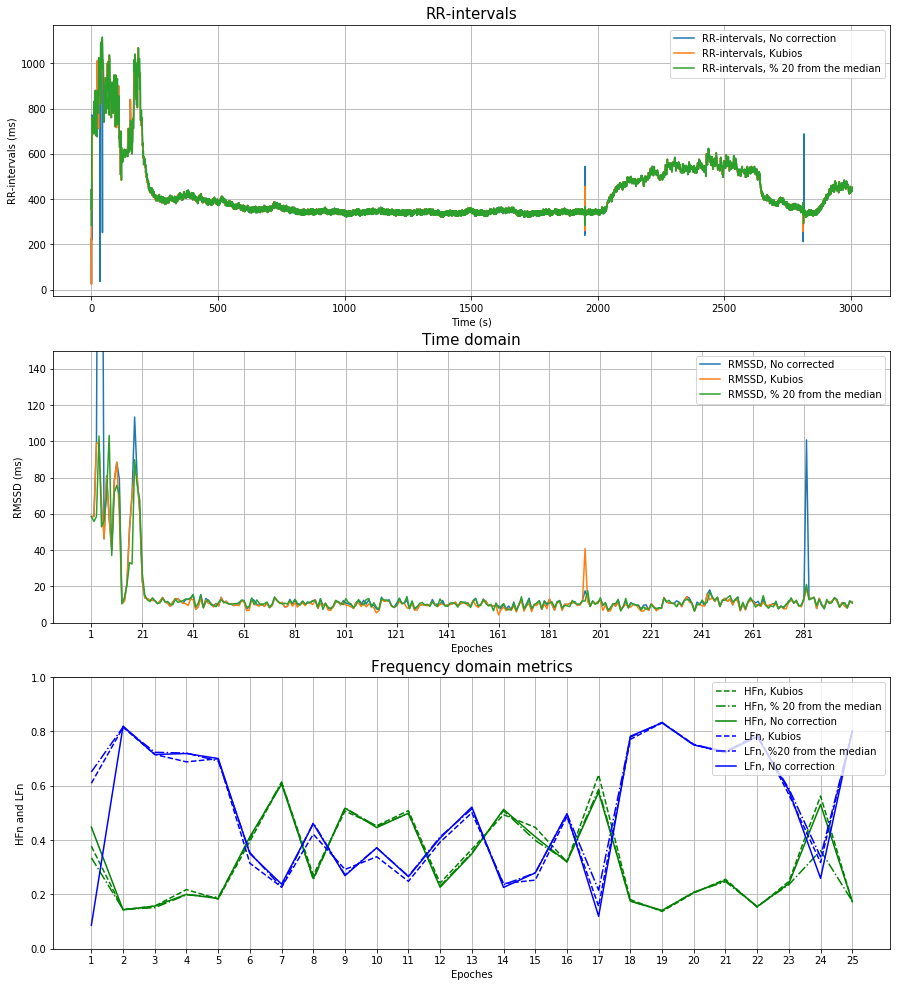

In [7]:
# Plot RR-intervals and corrected 
fig1, ax1 = plt.subplots(figsize=(15,17));

rr_nocorrectiontime = np.divide(rpeaks_nocorrection['ECG_R_Peaks'][:-1], sampling_rate)
rr_kubiostime = np.divide(rpeaks_kubios['ECG_R_Peaks'][:-1], sampling_rate)
rr_peaks20time = np.divide(rpeaks_20['ECG_R_Peaks'][:-1], sampling_rate)

plt.subplot(3,1,1)
plt.plot(rr_nocorrectiontime, (1000/sampling_rate) * np.diff(rpeaks_nocorrection['ECG_R_Peaks']),label='RR-intervals, No correction')
plt.plot(rr_kubiostime, (1000/sampling_rate) * np.diff(rpeaks_kubios['ECG_R_Peaks']),label ='RR-intervals, Kubios')
plt.plot(rr_peaks20time, (1000/sampling_rate) * np.diff(rpeaks_20['ECG_R_Peaks']),label='RR-intervals, % 20 from the median')
plt.xlabel('Time (s)')
plt.grid()
plt.ylabel('RR-intervals (ms)')
plt.title('RR-intervals', size = 15)
plt.legend()


# Epoches of 10 sec - Time Domain
# set first values as 0
hrv_epoches_nocorrection10['HRV_RMSSD'][0] = hrv_epoches_nocorrection10['HRV_RMSSD'][1]  
hrv_epoches_correctionkubios10['HRV_RMSSD'][0] = hrv_epoches_correctionkubios10['HRV_RMSSD'][1]  
hrv_epoches_correctionmedian10['HRV_RMSSD'][0] = hrv_epoches_correctionkubios10['HRV_RMSSD'][1]  

plt.subplot(3,1,2)
plt.plot(hrv_epoches_nocorrection10['HRV_RMSSD'],label='RMSSD, No corrected')
plt.plot(hrv_epoches_correctionkubios10['HRV_RMSSD'],label='RMSSD, Kubios')
plt.plot(hrv_epoches_correctionmedian10['HRV_RMSSD'],label='RMSSD, % 20 from the median')
plt.ylim([0, 150]);
plt.xticks(np.arange(0, 300, step=20))
plt.xlabel('Epoches')
plt.grid()
plt.ylabel('RMSSD (ms)')
plt.title('Time domain', size = 15)
plt.legend(loc='upper right');


# Epoches of 120 sec - Freq Domain
plt.subplot(3,1,3)
plt.plot(hrv_epoches_correctionkubios120['HRV_HFn'],'g--',label='HFn, Kubios')
plt.plot(hrv_epoches_correctionmedian120['HRV_HFn'],'g-.',label='HFn, % 20 from the median')
plt.plot(hrv_epoches_nocorrection120['HRV_HFn'],'g',label ='HFn, No correction' )
plt.plot(hrv_epoches_correctionkubios120['HRV_LFn'],'b--',label= 'LFn, Kubios')
plt.plot(hrv_epoches_correctionmedian120['HRV_LFn'],'b-.',label= 'LFn, %20 from the median')
plt.plot(hrv_epoches_nocorrection120['HRV_LFn'],'b',label = 'LFn, No correction')
plt.ylim([0, 1]);
plt.xlabel('Epoches')
plt.grid()
plt.title('Frequency domain metrics', size = 15)
plt.ylabel('HFn and LFn')
plt.legend(loc='upper right');


3) Case study: *20200520-TR-Belt.txt* , during run-rest-run

In [8]:
# NO ARTEFACT CORRECTION
# Load ECG session
pathname = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data"
activity = "Experiments"
record = "20200416-TR-FWv2series.txt"
pathname + "/" + activity + "/" + record

f = open(pathname + "/" + activity + "/" + record, 'r')
ecg = f.readlines()[4:]
f.close()

sampling_rate = 250

# Window size for epoches
time_window = 10
freq_window = 120

# Clean ECG (no pre-processing method using ASI)
ecg_cleaned = nk.ecg_clean(ecg,sampling_rate=sampling_rate, method='asi')


#========================
# No correction
# R-peaks detection
instant_peaks, rpeaks_nocorrection, = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,sampling_rate=sampling_rate,correct_artifacts=False)
rate = nk.signal_rate(rpeaks_nocorrection,sampling_rate=sampling_rate,desired_length=len(ecg_cleaned))
signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate})


# Have the right struture for epochs
signals = pd.concat([signals, instant_peaks], axis=1)

# Create epochs of the ecg signal for 10sec and 2min windows
ecg_epochs_time = nk.epochs_create(signals, sampling_rate = 250, epochs_end = time_window)
ecg_epochs_freq = nk.epochs_create(signals, sampling_rate = 250, epochs_end = freq_window)

# Compute HRV metrics over the ecg_epochs
hrv_epoches_nocorrection10 = nk.ecg_intervalrelated(ecg_epochs_time,sampling_rate = 250)
hrv_epoches_nocorrection120 = nk.ecg_intervalrelated(ecg_epochs_freq,sampling_rate = 250)


#========================
# Kubios: Lipponen & Tarvainen (2019) 
# R-peaks detection
instant_peaks, rpeaks_kubios, = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,sampling_rate=sampling_rate,correct_artifacts=True,methodcorrect='kubios')

# Avoid repetitive indexes
rpeaks_kubios['ECG_R_Peaks'] = np.unique(rpeaks_kubios['ECG_R_Peaks'])
rate = nk.signal_rate(rpeaks_kubios,sampling_rate=sampling_rate,desired_length=len(ecg_cleaned))
signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate})


# Have the right struture for epochs
signals = pd.concat([signals, instant_peaks], axis=1)

# Create epochs of the ecg signal
ecg_epochs_time = nk.epochs_create(signals, sampling_rate=250, epochs_end = time_window)
ecg_epochs_freq = nk.epochs_create(signals, sampling_rate=250, epochs_end = freq_window)

# Compute HRV metrics over the ecg_epochs
hrv_epoches_correctionkubios10 = nk.ecg_intervalrelated(ecg_epochs_time,sampling_rate = 250)
hrv_epoches_correctionkubios120 = nk.ecg_intervalrelated(ecg_epochs_freq,sampling_rate = 250)


#========================
# Deviation 20% from the mean
# R-peaks detection
instant_peaks, rpeaks_20 = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,sampling_rate=sampling_rate,correct_artifacts=True,methodcorrect='asi')

# Avoid several 0,0,0 at the beginning
rpeaks_20['ECG_R_Peaks'] = np.unique(rpeaks_20['ECG_R_Peaks'])

rate = nk.signal_rate(rpeaks_20,sampling_rate=sampling_rate,desired_length=len(ecg_cleaned))
signals = pd.DataFrame({"ECG_Raw": ecg,"ECG_Clean": ecg_cleaned,"ECG_Rate": rate})

# Have the right struture for epochs
signals = pd.concat([signals, instant_peaks], axis=1)


# Create epochs of the ecg signal
ecg_epochs_time = nk.epochs_create(signals, sampling_rate=250, epochs_end = time_window)
ecg_epochs_freq = nk.epochs_create(signals, sampling_rate=250, epochs_end = freq_window)

# Compute HRV metrics over the ecg_epochs
hrv_epoches_correctionmedian10 = nk.ecg_intervalrelated(ecg_epochs_time,sampling_rate=250)
hrv_epoches_correctionmedian120 = nk.ecg_intervalrelated(ecg_epochs_freq,sampling_rate=250)

/Users/tiagorodrigues/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


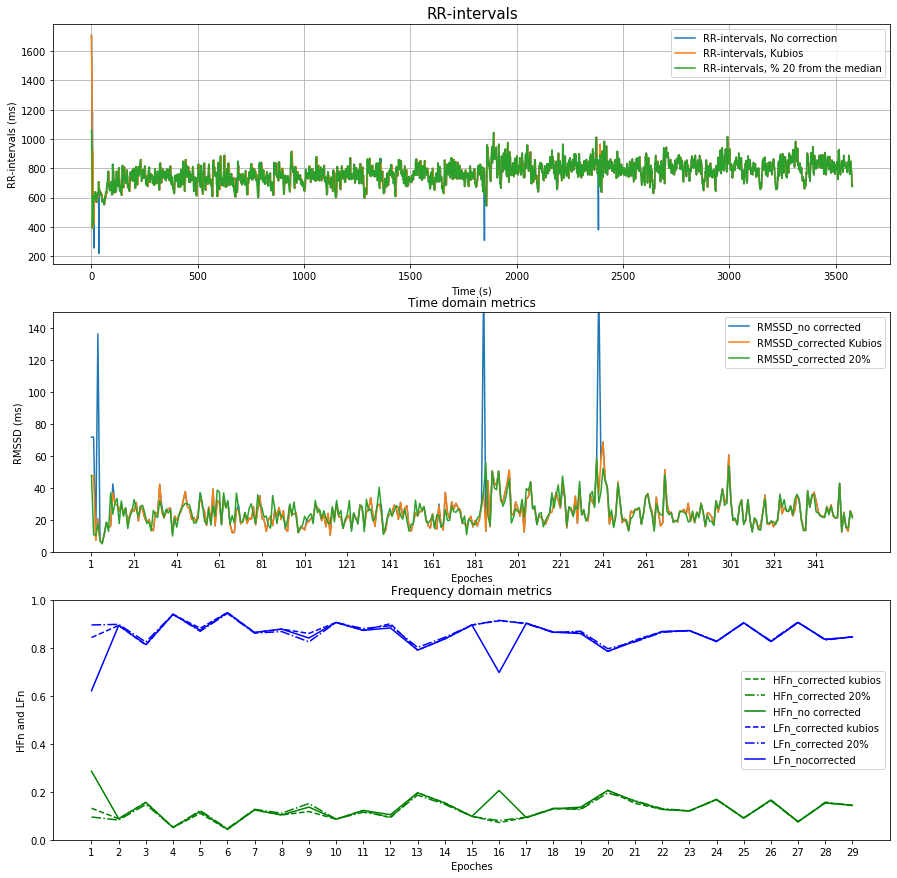

In [9]:
# Plot RR-intervals and corrected 
fig1, ax1 = plt.subplots(figsize=(15,15));
plt.subplot(3,1,1)

rr_nocorrectiontime = np.divide(rpeaks_nocorrection['ECG_R_Peaks'][:-1], sampling_rate)
rr_kubiostime = np.divide(rpeaks_kubios['ECG_R_Peaks'][:-1], sampling_rate)
rr_peaks20time = np.divide(rpeaks_20['ECG_R_Peaks'][:-1], sampling_rate)

plt.subplot(3,1,1)
plt.plot(rr_nocorrectiontime, (1000/sampling_rate) * np.diff(rpeaks_nocorrection['ECG_R_Peaks']),label='RR-intervals, No correction')
plt.plot(rr_kubiostime, (1000/sampling_rate) * np.diff(rpeaks_kubios['ECG_R_Peaks']),label ='RR-intervals, Kubios')
plt.plot(rr_peaks20time, (1000/sampling_rate) * np.diff(rpeaks_20['ECG_R_Peaks']),label='RR-intervals, % 20 from the median')
plt.xlabel('Time (s)')
plt.grid()
plt.ylabel('RR-intervals (ms)')
plt.title('RR-intervals', size = 15)
plt.legend()


# Epoches of 10 sec - Time Domain
# set first values as 0
hrv_epoches_nocorrection10['HRV_RMSSD'][0] = hrv_epoches_nocorrection10['HRV_RMSSD'][1]  
hrv_epoches_correctionkubios10['HRV_RMSSD'][0] = hrv_epoches_correctionkubios10['HRV_RMSSD'][1]  
hrv_epoches_correctionmedian10['HRV_RMSSD'][0] = hrv_epoches_correctionkubios10['HRV_RMSSD'][1]  

plt.subplot(3,1,2)
plt.plot(hrv_epoches_nocorrection10['HRV_RMSSD'],label='RMSSD_no corrected')
plt.plot(hrv_epoches_correctionkubios10['HRV_RMSSD'],label='RMSSD_corrected Kubios')
plt.plot(hrv_epoches_correctionmedian10['HRV_RMSSD'],label='RMSSD_corrected 20%')
plt.ylim([0, 150]);
plt.xticks(np.arange(0, 350, step=20))
plt.xlabel('Epoches')
plt.ylabel('RMSSD (ms)')
plt.title('Time domain metrics')
plt.legend();


# Epoches of 120 sec - Freq Domain
plt.subplot(3,1,3)
plt.plot(hrv_epoches_correctionkubios120['HRV_HFn'],'g--',label='HFn_corrected kubios')
plt.plot(hrv_epoches_correctionmedian120['HRV_HFn'],'g-.',label='HFn_corrected 20%')
plt.plot(hrv_epoches_nocorrection120['HRV_HFn'],'g',label ='HFn_no corrected' )
plt.plot(hrv_epoches_correctionkubios120['HRV_LFn'],'b--',label= 'LFn_corrected kubios')
plt.plot(hrv_epoches_correctionmedian120['HRV_LFn'],'b-.',label= 'LFn_corrected 20%')
plt.plot(hrv_epoches_nocorrection120['HRV_LFn'],'b',label = 'LFn_nocorrected')
plt.ylim([0, 1]);
plt.xlabel('Epoches')
plt.title('Frequency domain metrics')
plt.ylabel('HFn and LFn')
plt.legend();